In [ ]:
import os
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.stats.proportion import proportion_confint

from scipy.stats import beta

import warnings
warnings.filterwarnings("ignore")

tf.config.list_physical_devices('GPU')

plt.style.use('ggplot')

np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Funciones**

#### **Separacion / Organizacion datos entrada**

In [ ]:
def separar_organizar_d_entrada(d_raiz, d_entrenamiento, d_validacion, rango_corte, t_datos_entrenamiento=0.8):
    try:
        # Listar todas las carpetas dentro del rango especificado
        for folder in os.listdir(d_raiz):
            if os.path.isdir(os.path.join(d_raiz, folder)) and rango_corte[0] <= folder <= rango_corte[1]:
                folder_path = os.path.join(d_raiz, folder)
                files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

                # Desordenar los archivos para una división aleatoria
                shuffle(files)

                # Calcular el indice de corte para la division entrenamiento-validacion
                split_index = int(len(files) * t_datos_entrenamiento)
                train_files = files[:split_index]
                validation_files = files[split_index:]

                # Crear directorios especificos de carpeta dentro de train y validation
                train_folder_path = os.path.join(d_entrenamiento, folder)
                validation_folder_path = os.path.join(d_validacion, folder)
                os.makedirs(train_folder_path, exist_ok=True)
                os.makedirs(validation_folder_path, exist_ok=True)

                # Mover archivos a los directorios de entrenamiento y validación
                for file in train_files:
                    shutil.move(os.path.join(folder_path, file), os.path.join(train_folder_path, file))

                for file in validation_files:
                    shutil.move(os.path.join(folder_path, file), os.path.join(validation_folder_path, file))

                # Eliminar la carpeta original si está vacía
                if not os.listdir(folder_path):
                    os.rmdir(folder_path)

    except Exception as e:
        print(f"Error al organizar y dividir los datos: {e}")

#### **Modelos**

    Modelo con BatchNormalization = True

In [ ]:
def create_model_con_bn(learning_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

    Modelo con BatchNormalization = False

In [ ]:
def create_model_sin_bn(learning_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

#### **Graficas**

    Visualizar Train / Val de todos modelos

In [ ]:
def graficar_metricas(histories, metric):
    plt.figure(figsize=(18, 8))

    # Crear dos subplots: uno para el entrenamiento y otro para la validación
    plt.subplot(1, 2, 1)
    for history, model_info in zip(histories, models):
        train_values = history.history[metric]
        epochs = range(1, len(train_values) + 1)
        final_value = train_values[-1]
        plt.plot(epochs, train_values, label=f'{model_info[1]} (final: {final_value:.2f})')

    plt.title('Train', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for history, model_info in zip(histories, models):
        val_values = history.history['val_' + metric]
        epochs = range(1, len(val_values) + 1)
        final_value = val_values[-1]
        plt.plot(epochs, val_values, '--', label=f'{model_info[1]} (final: {final_value:.2f})')

    plt.title('Validation', fontsize=16, fontweight='bold')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    Curva ROC

In [ ]:
def plot_roc_curve(ax, y_true, y_scores, model_info):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive')
    ax.set_ylabel('True Positive')
    ax.set_title(f'Curva ROC', fontsize=10)
    ax.legend(loc='lower right')

    Especificidad / Sensibilidad entrenamiento

In [ ]:
def plot_specificity_sensitivity_train(ax, history, model_info):
    specificity = np.array(history.history['tn']) / (np.array(history.history['tn']) + np.array(history.history['fp']))
    sensitivity = np.array(history.history['tp']) / (np.array(history.history['tp']) + np.array(history.history['fn']))
    epochs = range(1, len(specificity) + 1)
    final_specificity = specificity[-1]
    final_sensitivity = sensitivity[-1]
    ax.plot(epochs, specificity, label=f'Especificidad Train {final_specificity:.2f}')
    ax.plot(epochs, sensitivity, label=f'Sensibilidad Train {final_sensitivity:.2f}')
    ax.set_xlabel('Epocas')
    ax.set_ylabel('Valor')
    ax.set_title(f'Especificidad y Sensibilidad Entrenamiento', fontsize=10)
    ax.legend(loc='lower right')

    Especificidad / Sensibilidad validacion

In [ ]:
def plot_specificity_sensitivity_val(ax, history, model_info):
    specificity = np.array(history.history['val_tn']) / (np.array(history.history['val_tn']) + np.array(history.history['val_fp']))
    sensitivity = np.array(history.history['val_tp']) / (np.array(history.history['val_tp']) + np.array(history.history['val_fn']))
    epochs = range(1, len(specificity) + 1)
    final_specificity = specificity[-1]
    final_sensitivity = sensitivity[-1]
    ax.plot(epochs, specificity, label=f'Especificidad Val {final_specificity:.2f}')
    ax.plot(epochs, sensitivity, label=f'Sensibilidad Val {final_sensitivity:.2f}')
    ax.set_xlabel('Epocas')
    ax.set_ylabel('Valor')
    ax.set_title(f'Especificidad y Sensibilidad Validacion', fontsize=10)
    ax.legend(loc='lower right')

    Matriz confusion

In [ ]:
def plot_confusion_matrix(ax, y_true, y_pred, model_info):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_xlabel('Predicho')
    ax.set_ylabel('True')
    ax.set_title(f'Matriz Confusion', fontsize=10)

    Mostrar Curva ROC / esp,sens / Matriz en un mismo plot

In [ ]:
def plot_all_metrics(histories, y_trues, y_scores, y_preds, models):
    n_models = len(models)
    fig, axes = plt.subplots(n_models, 4, figsize=(24, 6 * n_models))

    for i, (history, y_true, y_score, y_pred, model_info) in enumerate(zip(histories, y_trues, y_scores, y_preds, models)):
        # Agregar el título del modelo a la izquierda de la fila
        fig.text(0.04, 1 - (i + 0.5) / n_models, model_info[1], va='center', ha='center', rotation='vertical', fontsize=16, fontweight='bold')
        # Curva ROC
        plot_roc_curve(axes[i, 0], y_true, y_score, model_info[1])
        # Especificidad y Sensibilidad para entrenamiento
        plot_specificity_sensitivity_train(axes[i, 1], history, model_info[1])
        # Especificidad y Sensibilidad para validación
        plot_specificity_sensitivity_val(axes[i, 2], history, model_info[1])
        # Matriz de Confusión
        plot_confusion_matrix(axes[i, 3], y_true, y_pred, model_info[1])
    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.show()


    Obtener VPP / VPN

In [ ]:
def plot_vpp_vpn(ax, sensibilidad, especificidad, threshold):
    p_prev = np.linspace(0, 1, 1000)

    vpp = (sensibilidad * p_prev) / (sensibilidad * p_prev + (1 - especificidad) * (1 - p_prev))
    vpn = (especificidad * (1 - p_prev)) / ((1 - sensibilidad) * p_prev + especificidad * (1 - p_prev))

    ax.plot(p_prev, vpp, label="VPP", color="blue")
    ax.plot(p_prev, vpn, label="VPN", color="orange")

    # Linea vertical para el threshold
    ax.axvline(x=threshold, color='red', linestyle='--')

    ax.text(threshold, 0.5, f'{threshold:.3f}', color='red', fontsize=12, ha='center') # modificar?

    ax.set_xlabel('Prevalencia')
    ax.set_ylabel('Valores predictivos')
    ax.legend()
    ax.grid(True)
    ax.legend(loc='lower right')

In [ ]:
def calculate_metrics_at_best_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 1000)
    best_threshold = 0.5
    best_sensitivity = 0
    best_specificity = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        if sensitivity + specificity > best_sensitivity + best_specificity:
            best_threshold = threshold
            best_sensitivity = sensitivity
            best_specificity = specificity

    return best_sensitivity, best_specificity, best_threshold

    Intervalo confianza Jeffreys

In [ ]:
def calculate_confidence_intervals(success, total, confidence=0.95):
    lower_jeffreys, upper_jeffreys = proportion_confint(success, total, method="jeffreys", alpha=1-confidence)
    beta_a = 0.5 + success
    beta_b = 0.5 + total - success
    lower_bayes, upper_bayes = beta.interval(confidence, beta_a, beta_b)
    return (lower_jeffreys, upper_jeffreys), (lower_bayes, upper_bayes)

    Intervalo confianza

In [ ]:
def calculate_metrics_with_intervals(y_true, y_scores, confidence=0.95):
    thresholds = np.linspace(0, 1, 1000)
    best_threshold = 0.5
    best_sensitivity = 0
    best_specificity = 0
    best_cm = None

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        if sensitivity + specificity > best_sensitivity + best_specificity:
            best_threshold = threshold
            best_sensitivity = sensitivity
            best_specificity = specificity
            best_cm = cm

    tn, fp, fn, tp = best_cm.ravel()
    sens_intervals = calculate_confidence_intervals(tp, tp + fn, confidence)
    spec_intervals = calculate_confidence_intervals(tn, tn + fp, confidence)

    return best_sensitivity, best_specificity, best_threshold, sens_intervals, spec_intervals

    Graficar intervalos confianza

In [ ]:
def plot_confidence_intervals(models, sensitivities, specificities, sens_intervals, spec_intervals, metric_name):
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i, (sensitivity, specificity, sens_int, spec_int) in enumerate(zip(sensitivities, specificities, sens_intervals, spec_intervals)):
        color = colors[i % len(colors)]
        if metric_name == 'Sensitivity':
            lower, upper = sens_int[1]  # Usar el intervalo Bayes
            value = sensitivity
        else:
            lower, upper = spec_int[1]  # Usar el intervalo Bayes
            value = specificity

        # Corregir valores negativos
        lower = max(lower, 0)
        upper = max(upper, 0)
        value = max(value, 0)

        xerr = [[value - lower], [upper - value]]
        if value - lower < 0 or upper - value < 0:
            print(f"AVISO: Valor negativo en el modelo {i}. Se corrige a 0 (se elimina).")
            xerr = [[0], [0]]

        ax.errorbar(value, i, xerr=xerr, fmt='o', label=f'{models[i][1]}', color=color)

    ax.set_title(f'{metric_name} con intervalo de confianza')
    ax.set_xlabel(metric_name)
    ax.set_yticks(range(len(models)))
    ax.set_yticklabels([model[1] for model in models])
    ax.invert_yaxis()
    ax.grid(True)
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    plt.show()

## **1. Separar Imagenes en Train/Test**

In [ ]:
d_raiz = '/content/drive/MyDrive/DATA'

# Directorios para datos de entrenamiento y validación
train_menores = '/content/drive/MyDrive/DATA/train/menores_18'
validation_menores = '/content/drive/MyDrive/DATA/validation/menores_18'
train_mayores = '/content/drive/MyDrive/DATA/train/mayores_18'
validation_mayores = '/content/drive/MyDrive/DATA/validation/mayores_18'

# Menores de 18
separar_organizar_d_entrada(d_raiz, train_menores, validation_menores, ('001', '017'))

# Mayores de 18
separar_organizar_d_entrada(d_raiz, train_mayores, validation_mayores, ('018', '110'))

print("Proceso de organización y división de archivos completado.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DATA/061/524.png'

## **2. Preparacion de los datos**

In [ ]:
train_dir = '/content/drive/MyDrive/DATA/train'
validation_dir = '/content/drive/MyDrive/DATA/validation'

# Crear datasets de imágenes
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=True)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=False)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7785 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


### **Temp para tomas**

## **3. Entrenamiento del modelo**

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [32, 64]
use_batch_norm_options = [True, False]

models = []
histories = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for use_bn in use_batch_norm_options:
            if use_bn == True:
                print("---")
                model = create_model_con_bn(lr)
                history = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpoint])
                models.append((model, f"LR={lr}, BS={batch_size}, BN={use_bn}"))
                histories.append(history)
            if use_bn == False:
                print("---")
                model = create_model_sin_bn(lr)
                history = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    batch_size=batch_size,
                    callbacks=[early_stopping, checkpoint])
                models.append((model, f"LR={lr}, BS={batch_size}, BN={use_bn}"))
                histories.append(history)

---
Epoch 1/5
244/244 [==============================] - 436s 2s/step - loss: 0.6289 - tp: 1454.0000 - tn: 3727.0000 - fp: 780.0000 - fn: 1824.0000 - val_loss: 6.2601 - val_tp: 828.0000 - val_tn: 0.0000e+00 - val_fp: 1172.0000 - val_fn: 0.0000e+00
Epoch 2/5
244/244 [==============================] - 18s 72ms/step - loss: 0.4922 - tp: 2007.0000 - tn: 3946.0000 - fp: 561.0000 - fn: 1271.0000 - val_loss: 1.1538 - val_tp: 0.0000e+00 - val_tn: 1172.0000 - val_fp: 0.0000e+00 - val_fn: 828.0000
Epoch 3/5
244/244 [==============================] - 18s 72ms/step - loss: 0.3719 - tp: 2422.0000 - tn: 4112.0000 - fp: 395.0000 - fn: 856.0000 - val_loss: 1.2266 - val_tp: 810.0000 - val_tn: 84.0000 - val_fp: 1088.0000 - val_fn: 18.0000
Epoch 4/5
244/244 [==============================] - 18s 74ms/step - loss: 0.2935 - tp: 2644.0000 - tn: 4150.0000 - fp: 357.0000 - fn: 634.0000 - val_loss: 0.3657 - val_tp: 535.0000 - val_tn: 1133.0000 - val_fp: 39.0000 - val_fn: 293.0000
Epoch 5/5
244/244 [===========

## **4. Realizar graficas**

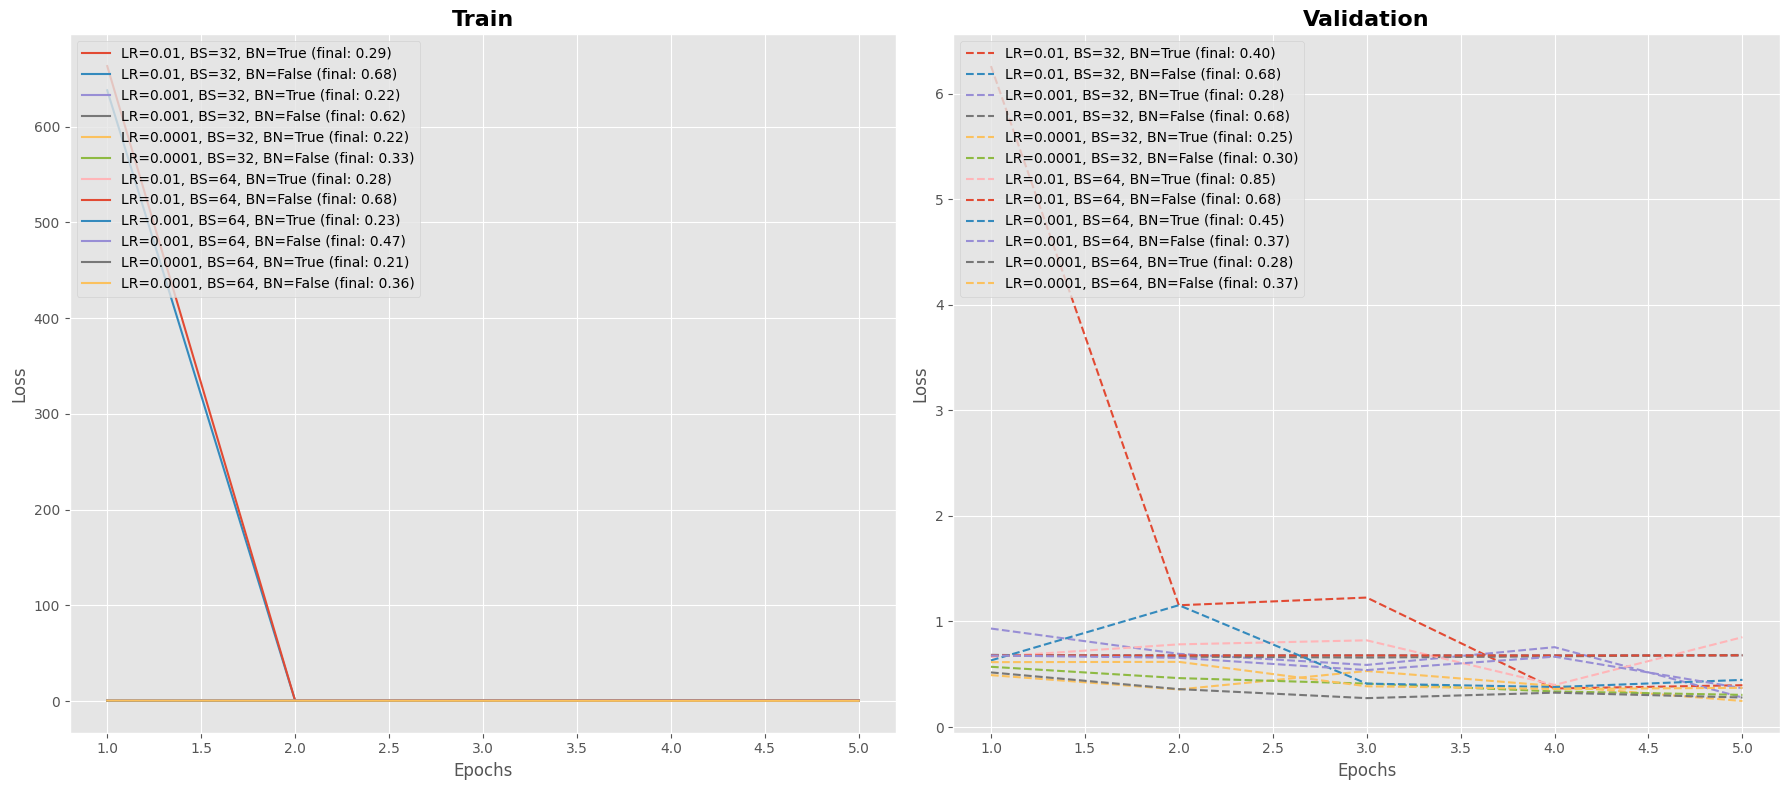

In [ ]:
graficar_metricas(histories, 'loss')

---

Al analizar las curvas de perdida (loss) para el entrenamiento y la validacion, se puede observar que los modelos con **tasas de aprendizaje mas bajas (LR=0.0001)** muestran curvas de perdida **más estables y bajas** en comparación con aquellos con tasas de aprendizaje más elevadas (LR=0.01) Los modelos con **Batch Normalization (BN=True)** tienen una **perdida menor** tanto en el entrenamiento como en la validacion, en comparación con aquellos sin Batch Normalization (BN=False) Esto nos da entener que **las tasas de aprendizaje elevadas posibilitan al modelo aprender de manera mas gradual**, evitando grandes caidas o subidas en la función de perdida, lo cual **incrementa la estabilidad y el rendimiento**. Asimismo, el Batch Normalization ayuda a estabilizar y mejorar el entrenamiento, lo cual conduce a una pérdida más baja y estable.

---

In [ ]:
y_trues = []
y_scores = []
y_preds = []
for model, _ in models:
    y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
    y_score = model.predict(validation_dataset);
    y_pred = (y_score > 0.5).astype(int)

    y_trues.append(y_true)
    y_scores.append(y_score)
    y_preds.append(y_pred)

63/63 [==============================] - 2s 36ms/step


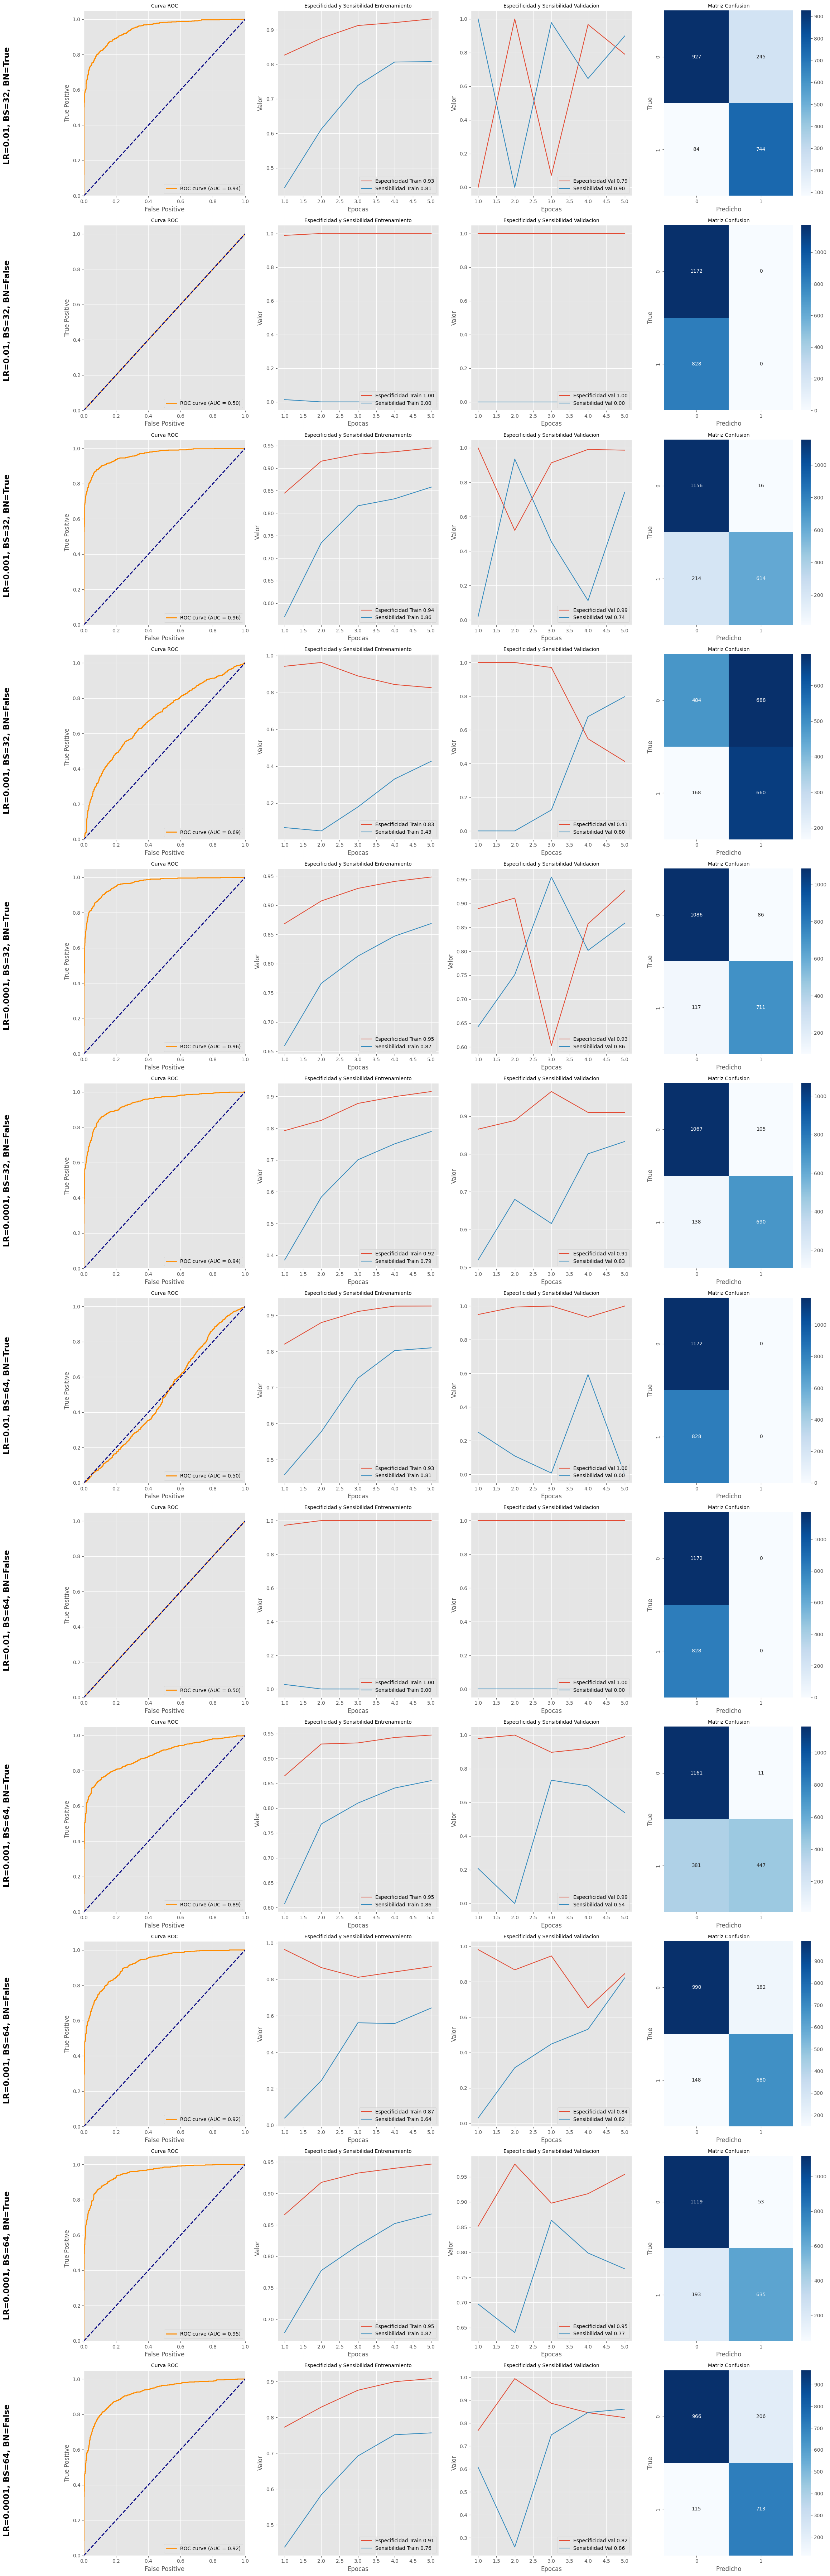

In [ ]:
plot_all_metrics(histories, y_trues, y_scores, y_preds, models)

---

Las curvas ROC indican que los modelos con **LR=0.0001** y **BN=True** tienen areas bajo la curva (AUC) mas elevadas, lo cual demuestra **un buen rendimiento** de estos modelos. Los modelos con tasas de aprendizaje elevadas (LR=0.01) y sin Batch Normalization (BN=False) presentan un rendimiento bajo con un AUC elevado. Un **AUC alto** sugiere que el **modelo es efectivo para distinguir entre clases** (menores y mayores de edad) **Los modelos con Batch Normalization y tasas de aprendizaje bajas muestran un rendimiento superior, este lo podemos observar en las matrices de confusion a la hora de distinguir entre los TP y TN.**

---

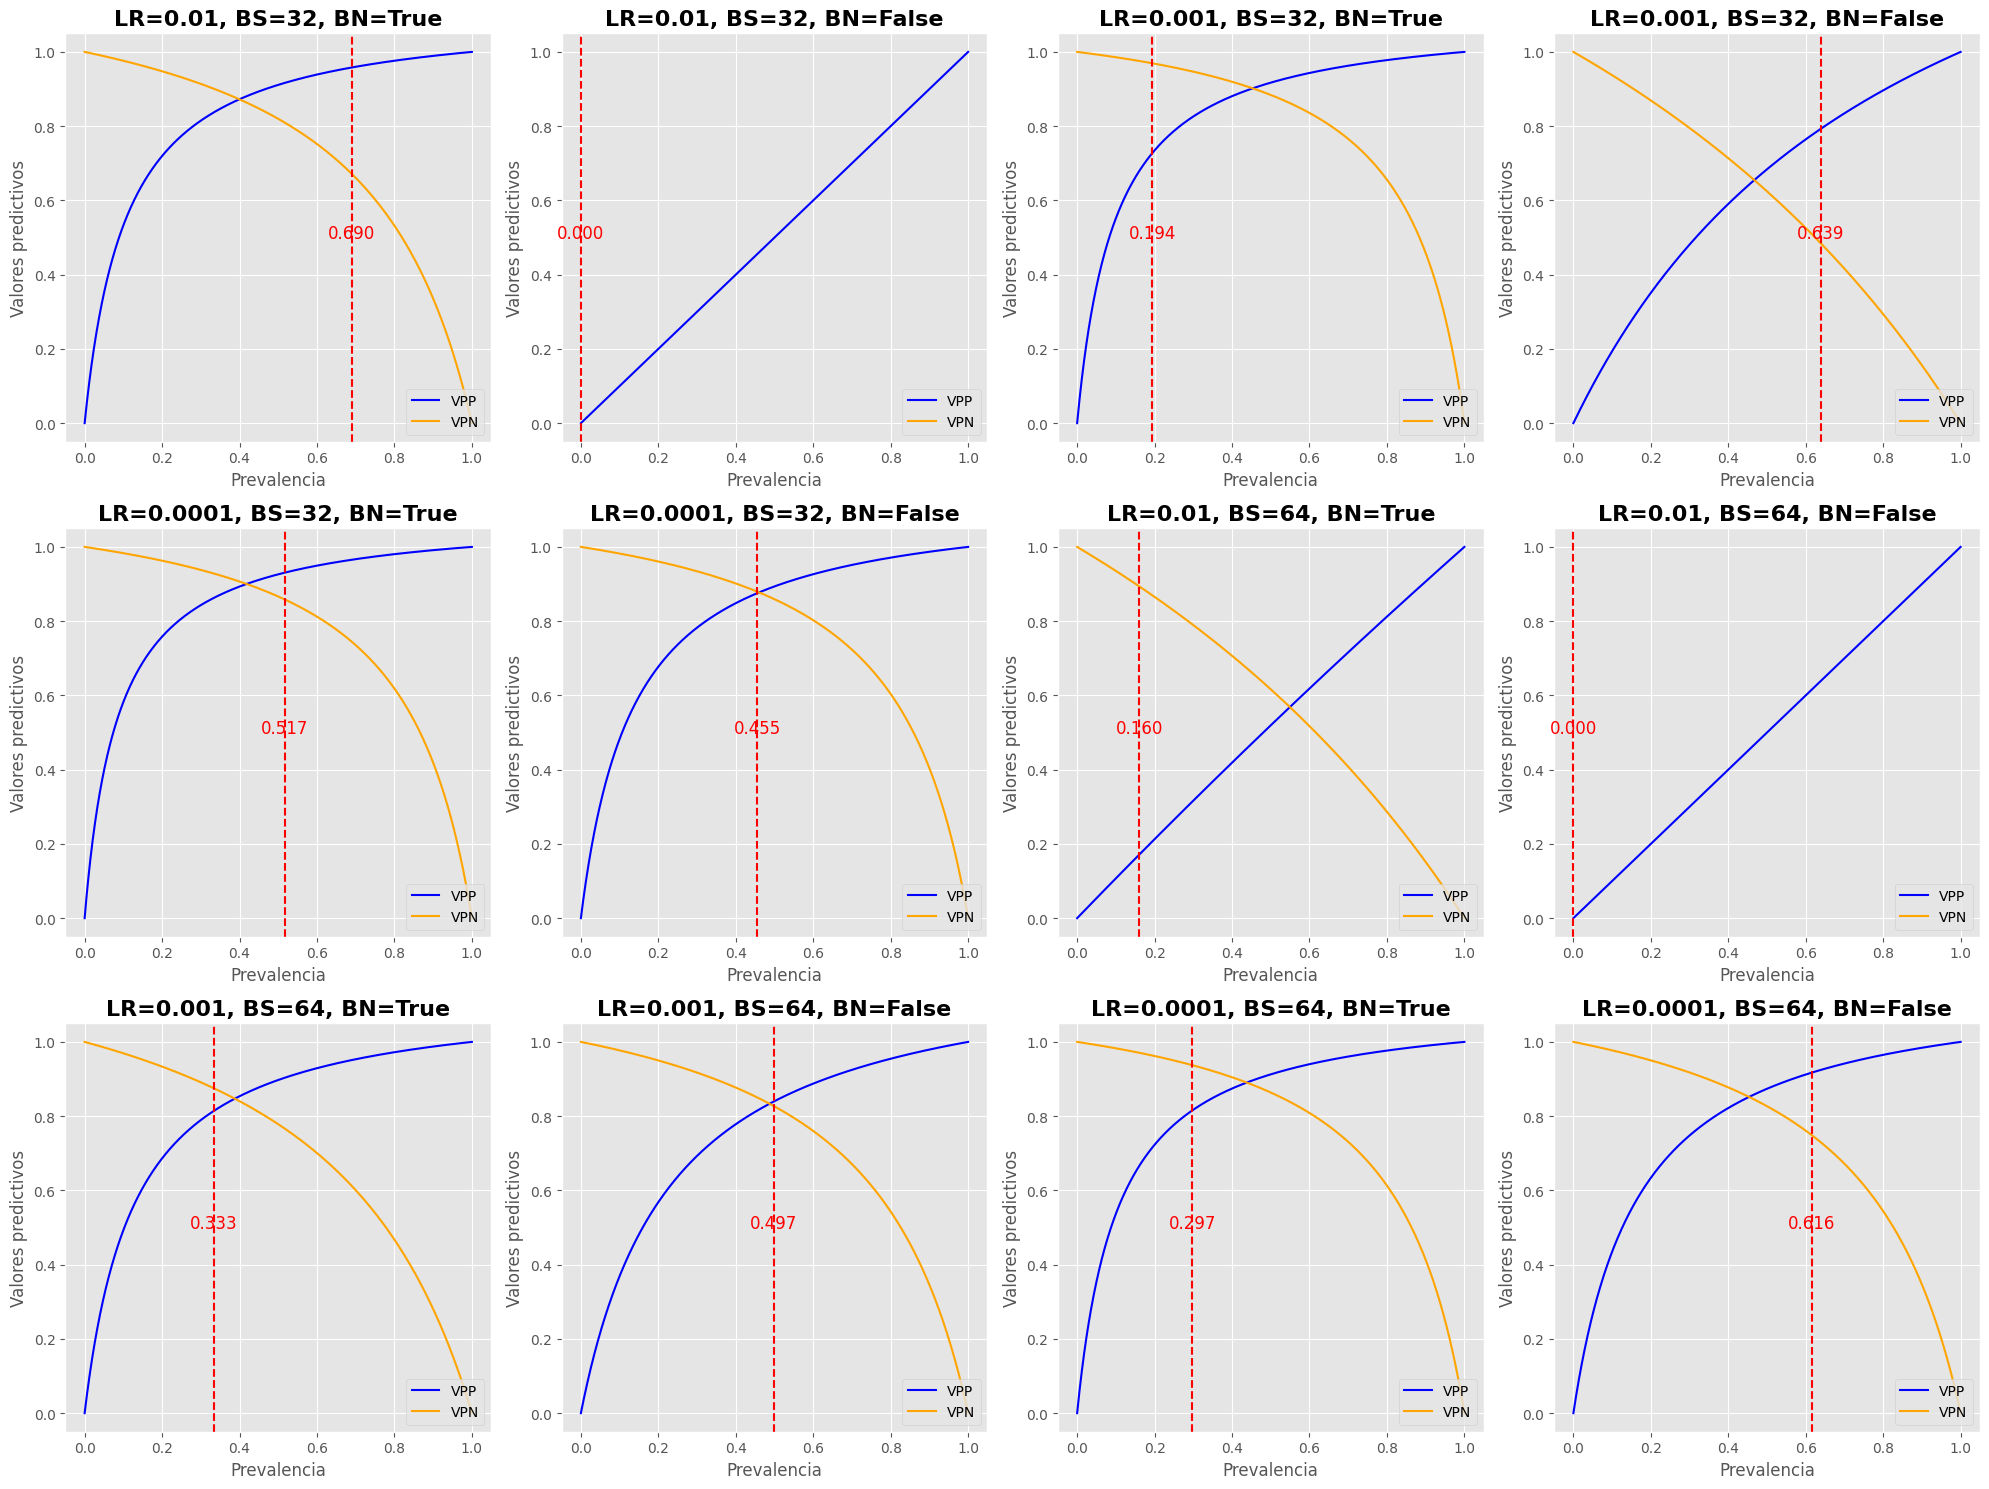

In [ ]:
# Crear subplots de 3x4
n_models = len(models)
n_cols, n_rows = 4, 3
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

for i, (y_true, y_score, model_info) in enumerate(zip(y_trues, y_scores, models)):
    row = i // n_cols
    col = i % n_cols
    best_sensitivity, best_specificity, best_threshold = calculate_metrics_at_best_threshold(y_true, y_score)
    plot_vpp_vpn(axes[row, col], best_sensitivity, best_specificity, best_threshold)
    axes[row, col].set_title(model_info[1], fontsize=16, fontweight='bold')

# Ocultar subplots vacíos si hay menos de 12 modelos
for j in range(i + 1, n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

---

Los modelos con **LR=0.0001 y BN=True** presentan una combinacion adecuada de alta sensibilidad y especificidad. Los modelos con LR=0.01 y BN=False tienen una especificidad muy elevada, lo cual demuestra una elevada tasa de falsos positivos. La sensibilidad elevada es importante para detectar de manera adecuada a las personas mayores de edad. La especificidad elevada es fundamental para disminuir los falsos positivos, asegurando que los menores de edad no sean clasificados de manera incorrecta como mayores de edad. **Un equilibrio adecuado entre la sensibilidad y la especificidad es fundamental para un modelo fiable.**

---

In [ ]:
sensitivities = []
specificities = []
sens_intervals = []
spec_intervals = []

for i, (y_true, y_score, model_info) in enumerate(zip(y_trues, y_scores, models)):
    best_sensitivity, best_specificity, best_threshold, sens_interval, spec_interval = calculate_metrics_with_intervals(y_true, y_score)
    sensitivities.append(best_sensitivity)
    specificities.append(best_specificity)
    sens_intervals.append(sens_interval)
    spec_intervals.append(spec_interval)
    histories[i].history['val_sensitivity'] = [best_sensitivity]
    histories[i].history['val_specificity'] = [best_specificity]

AVISO: Valor negativo en el modelo 1. Se corrige a 0 (se elimina).
AVISO: Valor negativo en el modelo 7. Se corrige a 0 (se elimina).


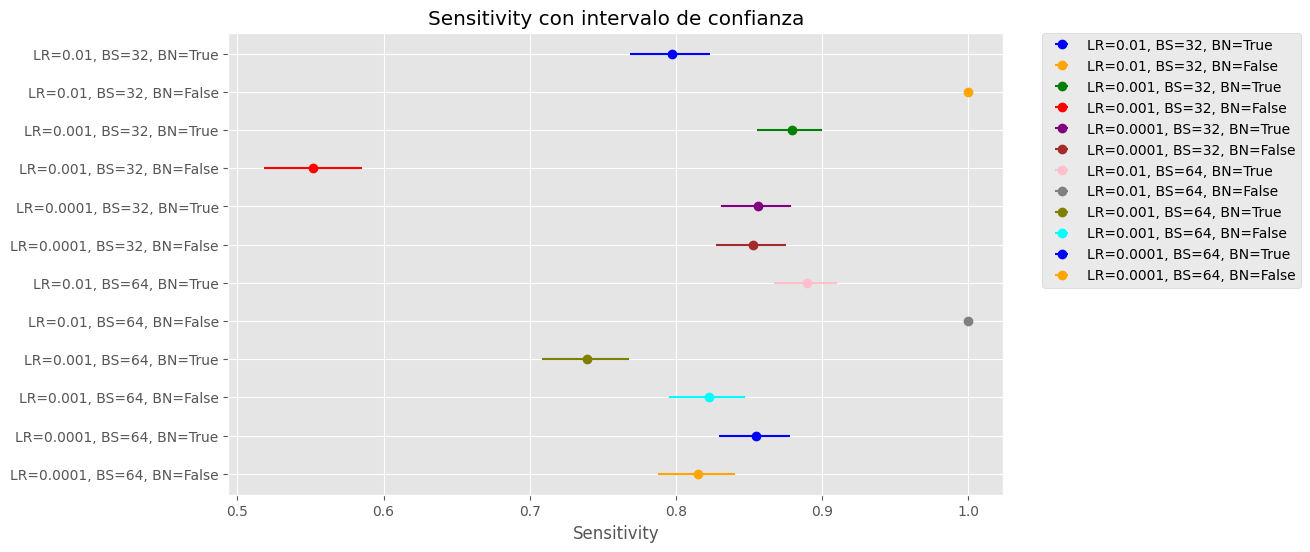

LR=0.01, BS=32, BN=True (Sensibilidad) = [0.7687, 0.8234]
LR=0.01, BS=32, BN=False (Sensibilidad) = [0.9970, 1.0000]
LR=0.001, BS=32, BN=True (Sensibilidad) = [0.8557, 0.9001]
LR=0.001, BS=32, BN=False (Sensibilidad) = [0.5179, 0.5856]
LR=0.0001, BS=32, BN=True (Sensibilidad) = [0.8312, 0.8789]
LR=0.0001, BS=32, BN=False (Sensibilidad) = [0.8273, 0.8756]
LR=0.01, BS=64, BN=True (Sensibilidad) = [0.8674, 0.9100]
LR=0.01, BS=64, BN=False (Sensibilidad) = [0.9970, 1.0000]
LR=0.001, BS=64, BN=True (Sensibilidad) = [0.7084, 0.7682]
LR=0.001, BS=64, BN=False (Sensibilidad) = [0.7953, 0.8473]
LR=0.0001, BS=64, BN=True (Sensibilidad) = [0.8299, 0.8778]
LR=0.0001, BS=64, BN=False (Sensibilidad) = [0.7877, 0.8405]
AVISO: Valor negativo en el modelo 1. Se corrige a 0 (se elimina).
AVISO: Valor negativo en el modelo 7. Se corrige a 0 (se elimina).


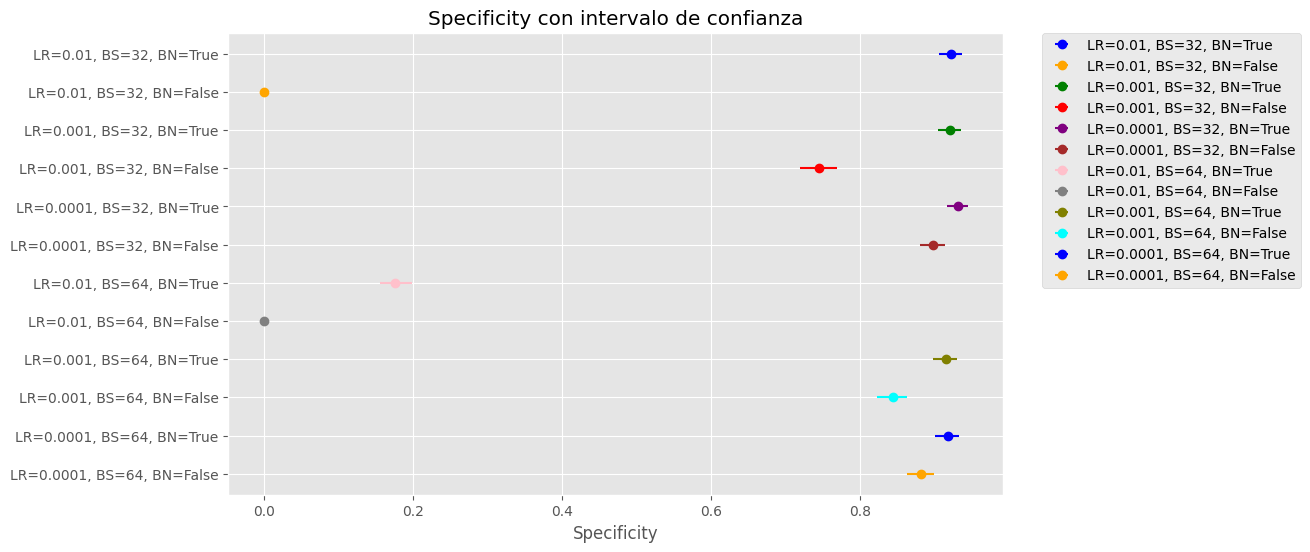

LR=0.01, BS=32, BN=True (Especificidad) = [0.9060, 0.9366]
LR=0.01, BS=32, BN=False (Especificidad) = [0.0000, 0.0021]
LR=0.001, BS=32, BN=True (Especificidad) = [0.9041, 0.9351]
LR=0.001, BS=32, BN=False (Especificidad) = [0.7193, 0.7692]
LR=0.0001, BS=32, BN=True (Especificidad) = [0.9162, 0.9451]
LR=0.0001, BS=32, BN=False (Especificidad) = [0.8802, 0.9148]
LR=0.01, BS=64, BN=True (Especificidad) = [0.1556, 0.1992]
LR=0.01, BS=64, BN=False (Especificidad) = [0.0000, 0.0021]
LR=0.001, BS=64, BN=True (Especificidad) = [0.8986, 0.9304]
LR=0.001, BS=64, BN=False (Especificidad) = [0.8222, 0.8638]
LR=0.0001, BS=64, BN=True (Especificidad) = [0.9014, 0.9328]
LR=0.0001, BS=64, BN=False (Especificidad) = [0.8629, 0.8998]


In [ ]:
plot_confidence_intervals(models, sensitivities, specificities, sens_intervals, spec_intervals, 'Sensitivity')
for i, (model_info, sens_interval, spec_interval) in enumerate(zip(models, sens_intervals, spec_intervals)):
    print(f"{model_info[1]} (Sensibilidad) = [{sens_interval[1][0]:.4f}, {sens_interval[1][1]:.4f}]")
plot_confidence_intervals(models, sensitivities, specificities, sens_intervals, spec_intervals, 'Specificity')
for i, (model_info, sens_interval, spec_interval) in enumerate(zip(models, sens_intervals, spec_intervals)):
    print(f"{model_info[1]} (Especificidad) = [{spec_interval[1][0]:.4f}, {spec_interval[1][1]:.4f}]")

---

 Los intervalos de confianza para los modelos con LR=0.0001 y BN=True son relativamente pequeños y elevados, lo que sugiere alta precisión en sus metricas. Los modelos con LR=0.01 y BN=False tienen intervalos de confianza amplios, lo que indicaria que sus resultados podrian no ser muy exactos segun sus metricas. **Modelos con menor rango en sus metricas son preferibles, ya que ofrecen resultados mas predecibles.**

---

## **5. Conclusion final**

**El modelo con LR=0.0001, BS=32, BN=True es el mas 'adaptado' para determinar si la cara es de un menor de edad o no**. Este modelo muestra una perdida baja y estable, lo cual demuestra un buen ajuste del modelo. Asimismo, cuenta con un elevado AUC en la curva ROC, lo cual demuestra una excelente capacidad de filtrado entre clases. La combinacion de alta sensibilidad y especificidad sugiere que el modelo minimiza tanto los falsos negativos como los falsos positivos. **Este modelo logra un equilibrio optimo, teniendo en cuenta tanto la identificación adecuada de menores de edad como la evitar falsos positivos, lo cual es fundamental para nuestro objetivo final, filtrar fotos sensibles (de menores).**

## **Modelo final -> LR=0.0001, BS=32, BN=True**